# Prototype Solver for Mandel et al.'s Wildfire Model

In [1]:
import numpy as np

import scipy.linalg # needed for matrix exponential

import matplotlib.pyplot as plt
import cmocean
import cmocean.cm as cmo

import time

%config InlineBackend.figure_format='retina'

$$
\frac{\partial T}{\partial t} = \left(\Delta-\mu\right) T + Se^{-\frac{1}{T}}
\\
\frac{\partial S}{\partial t} = -\beta Se^{-\frac{1}{T}}
$$

with $T(x,t)$ satisfy homogeneous Dirichlet BCs (fixed ambient reference temperature of $0$) and $S(x,t)$ satistfying homogeneous Neumann BCs (no flux across boundary). 

In [2]:
# define parameters
# mu = 2.7e-2 # mu=0.1 works rn too! 
# beta = 0.4829

k = (2.136e-1)/(500**2)

A = 1.8793e2

B = 5.5849e2

C = 4.8372e-5

CS = 1.625e-1

tmax = 2.3e3 # time to run simulation up to

# first, let's just set domain to be [-1,1] for simplicity, so I don't have to screw with my
# Chebyshev stuff

In [3]:
# First, let's make sure we can resolve the Arrhenius reaction term properly... 
# it's smooth but not analytic! 

def arrhenius(T): 
    
    T = np.array(T) # technical step for handling inputs that are 
    # vanilla floats that don't live in an array
    
    out = np.zeros_like(T, dtype=float)
    
    eps0 = 1e-14
    
    out[T<eps0] = 0. 
        
    out[T>=eps0] = np.exp(-B/T[T>=eps0])
    
    return out

In [4]:
arrhenius(0.)

array(0.)

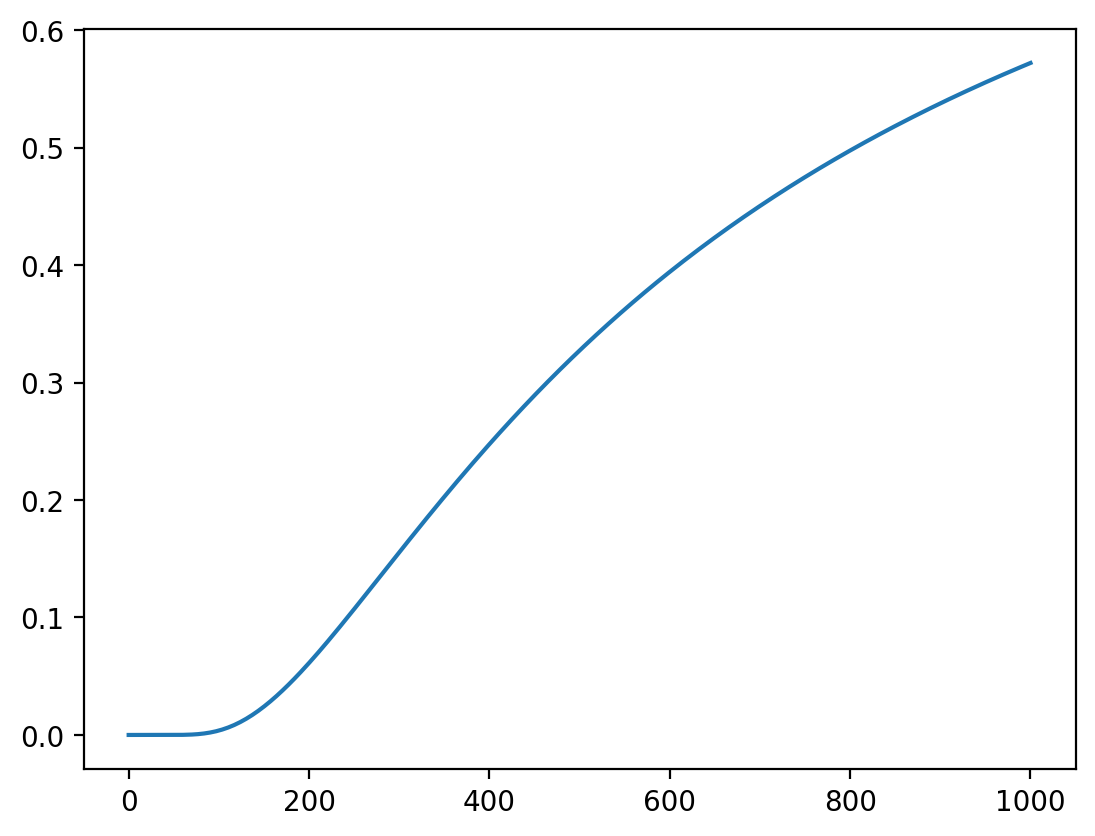

In [5]:
tt = np.linspace(0,1e3,300)
aa = arrhenius(tt)

plt.plot(tt,aa)
plt.show()

Our convention is that the state at time $t$ is denoted by 
$$
u(x,t)=(T(x,t), S(x,t))^{\mathrm{T}}
$$
When space is discretized into $N$ nodes, the discrete state $U$ at any given time is 
$$
U \in \mathbb{R}^{2\times N}. 
$$

In [6]:
# define initial states
def initial_state(x): 
        
    TC = 1.2e3
    width = 10.*np.sqrt(2)/500
    T0 = TC*np.exp(-(x/width)**2)
    
    S0 = 1.-0.99*np.exp(-(x/width)**2)
    
    #S0 = np.zeros_like(x, dtype=float)
    
    return np.array([T0, S0]) # output as a 2*length(x) array

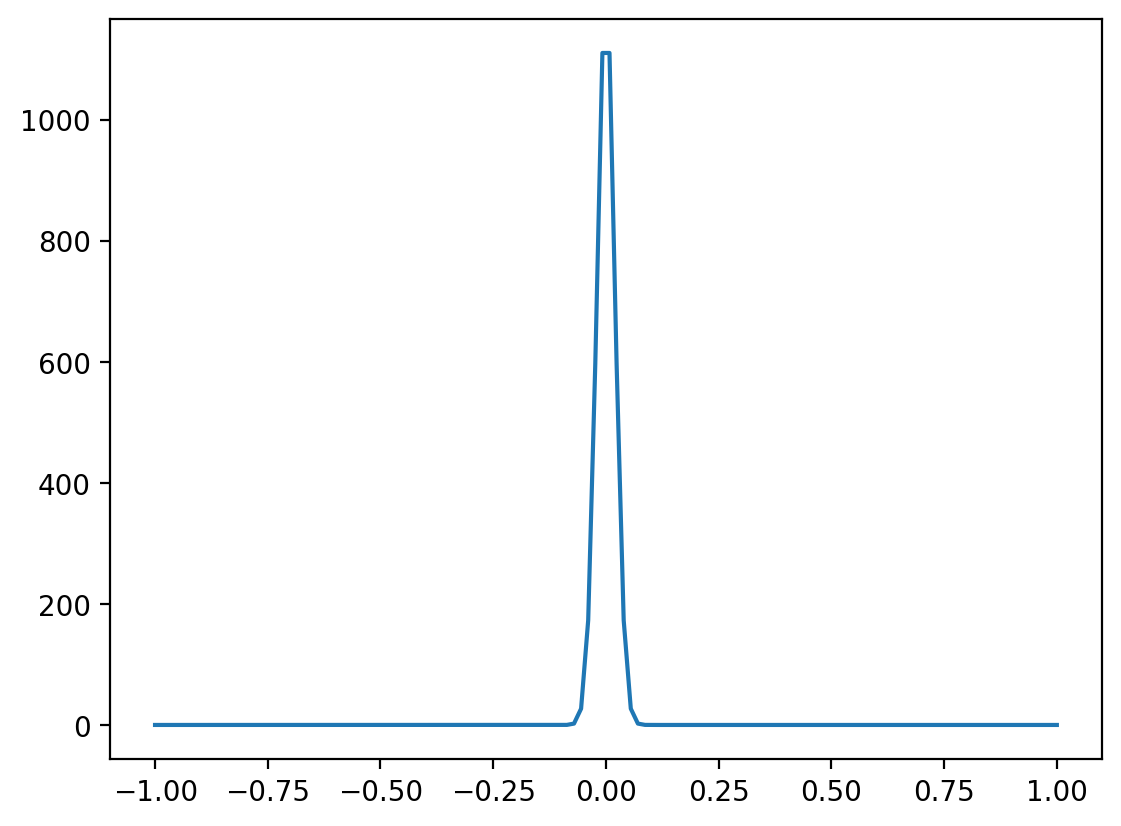

In [7]:
xx = np.linspace(-1,1, num=128, endpoint=True)
yy = initial_state(xx)[0]
plt.plot(xx,yy)
plt.show()

In [8]:
# forcing only important for temperature evolution 
def forcing(u):
    
    out = np.zeros([np.shape(u)[0]], dtype=float)
    
    T = u[0,:]
    
    S = u[1,:]
    
    out = A*S*arrhenius(T)
    
    return out  

In [9]:
def chebnodes(N):
# spits out an array of the n^th Chebyshev nodes in [-1,1]. NOTE: the output is arranged so 
# x[-1] = -1, x[0]=1. In other words, the grid is presented right-to-left instead.
# This is consistent with the convention in Trefethen's book

    theta = (np.pi/(N))*np.arange(0,N+1, dtype=int)
    
    x = np.cos(theta)
    
    return x

def chebdiff(N):
# spits out N+1 x N+1 Chebyshev differentiation matrix 

    c = np.ones([N+1,1])
    
    c[0] = 2.
    
    c[-1] = 2. 
    
    c = (c*(-1)**np.arange(0,N+1)).T
    
    x = chebnodes(N)
        
    X = np.tile(x,[N+1,1])
    
    dX = X - X.T
        
    D = c*(1./c.T)/(dX + np.identity(N+1))
        
    D -= np.diag(np.sum(D.T, axis=1))
    
    return D.T

In [10]:
start = time.time()
N = 1024 # spatial resolution 

x = chebnodes(N)

D = chebdiff(N)
D2 = np.linalg.matrix_power(D,2)[1:N, 1:N] # square D, then kill the non-contributing bdry pieces.

In [11]:
dt = 2**-5 # time step size

nsteps = int(tmax/dt) # total num of time steps we take

In [12]:
matA = k*D2 - A*C*np.eye(N-1) # matrix we need to deal with frequently, discretized linear (diffusive) part of PDE

# define approximate linear propagator over a time step
propagator = scipy.linalg.expm(dt*matA)

# now figure out the phi1-function by solving a matrix equation (directly)
phi1 = scipy.linalg.solve(matA, propagator-np.eye(N-1))

In [13]:
ndump = 1e1

uinit = initial_state(x)

uold = uinit[:,1:N]

Told = uold[0,:]

Sold = uold[1,:] # will have to fix later when we account for boundary stuff better

# make data storage array
udata = np.zeros([2, int(nsteps/ndump), N+1], dtype=float)
udata[:,0,:] = uinit

cnt = 0. # counter 

for n in np.arange(1,nsteps): 
    
    f = forcing(uold)
    
    # step temperature forward 
    Tnew = Told + phi1 @ (matA@Told + f)
    
    # step the fuel density forward, w/ vanilla forward Euler for now
    Snew = Sold*(1. - CS*dt*arrhenius(Told))
        
    # enforce BCs on S?????
    
    Told = Tnew
    
    Sold = Snew
    
    #plt.plot(x[1:N],Told)
    #plt.show()
    
    cnt+=1
    
    if cnt%ndump == 0: 
        
        uold = np.array([Told, Sold])
        
        udata[:,int(n/ndump),1:N] = uold 
        
    else: 
        
        pass
end = time.time()

In [14]:
runtime=end-start
print('Simulation runtime = %.3f' %runtime,'s' )

Simulation runtime = 135.800 s


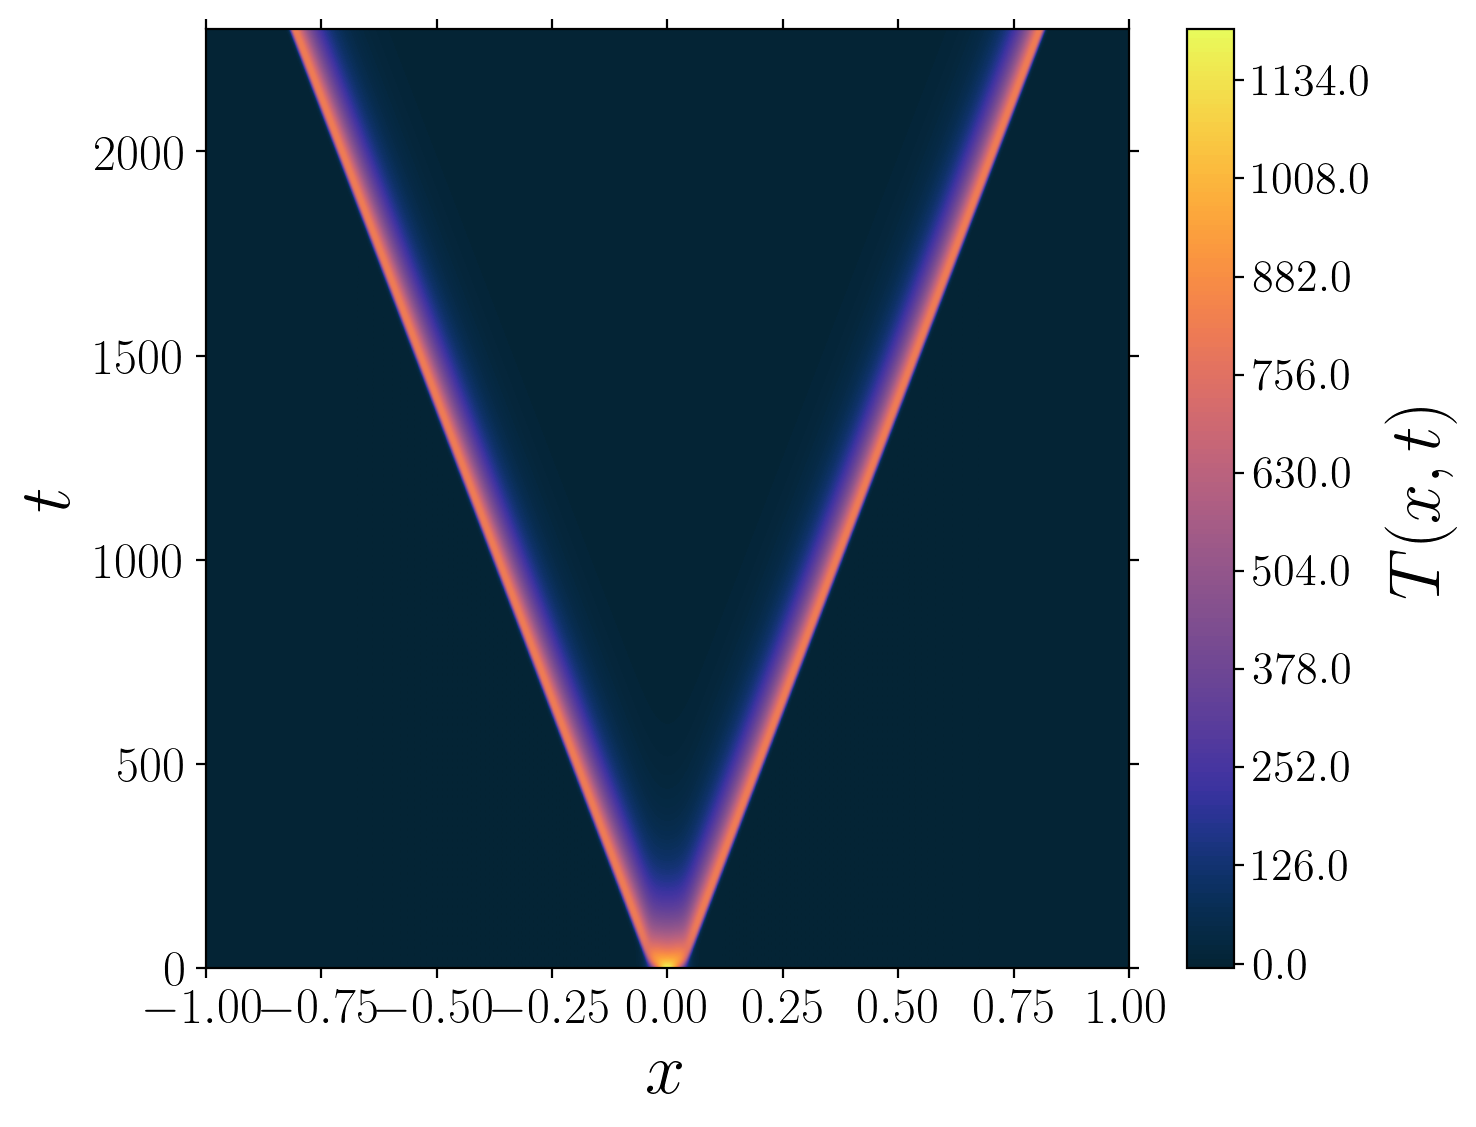

In [19]:
# MAKE FILLED CONTOUR PLOT OF SOLN
textcolor='k'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure()

times = np.linspace(0., tmax, num=int(nsteps/ndump), endpoint=True)

CF = plt.contourf(x,times,udata[0,:,:], levels=200, cmap = cmo.thermal)

# axis labels
plt.xlabel(r"$x$", fontsize=26, color = textcolor)
plt.ylabel(r"$t$", fontsize=26, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=18, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=18, rotation=0, color = textcolor)

# make colorbar
cbar = plt.colorbar(CF,  format='%.1f')
cbar.ax.tick_params(labelsize=16, color=textcolor) 
#plt.clim(0,np.amax(z))
cbar.ax.set_ylabel(r'$T(x,t)$', fontsize=26, color=textcolor)

# the final piece of the colorbar defn is to change the colorbar ticks to an acceptable color.
# This is not so easy, and relies on the thread at
# https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
figname = 'mandel_combustion_wave_sim.png'
plt.savefig(figname, dpi=600)

plt.show()

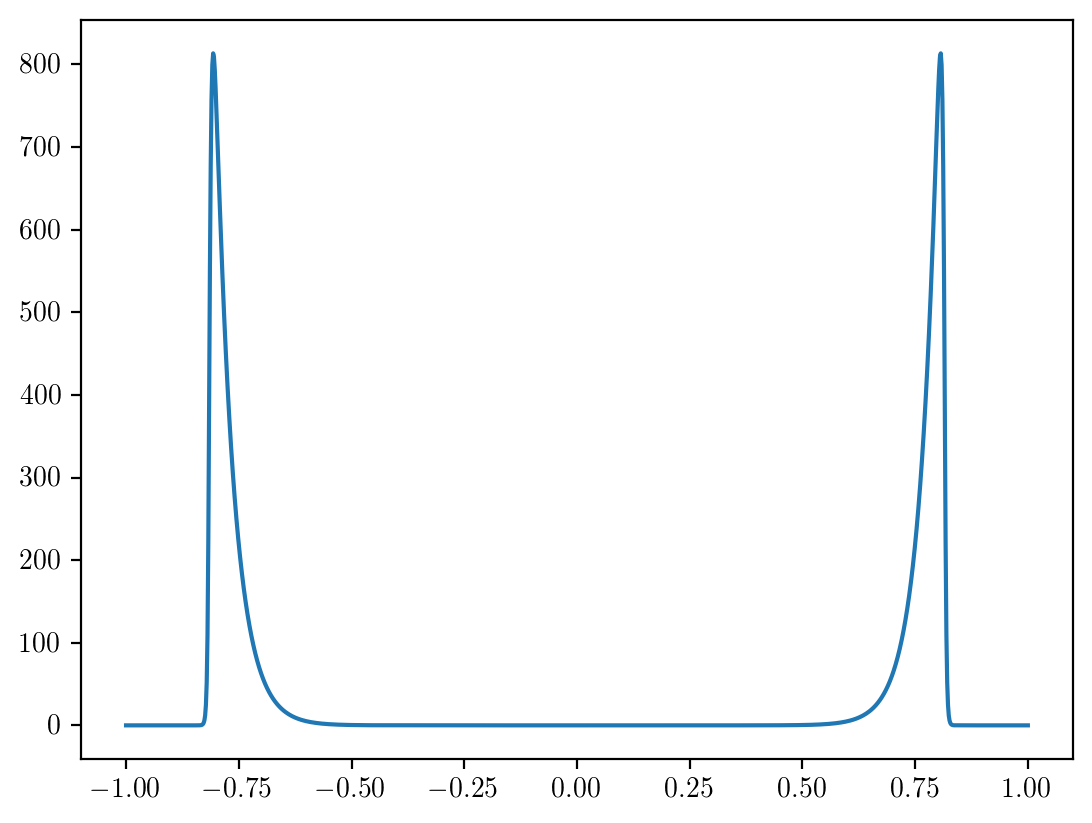

In [16]:
plt.plot(x, udata[0,-1,:])
plt.show()

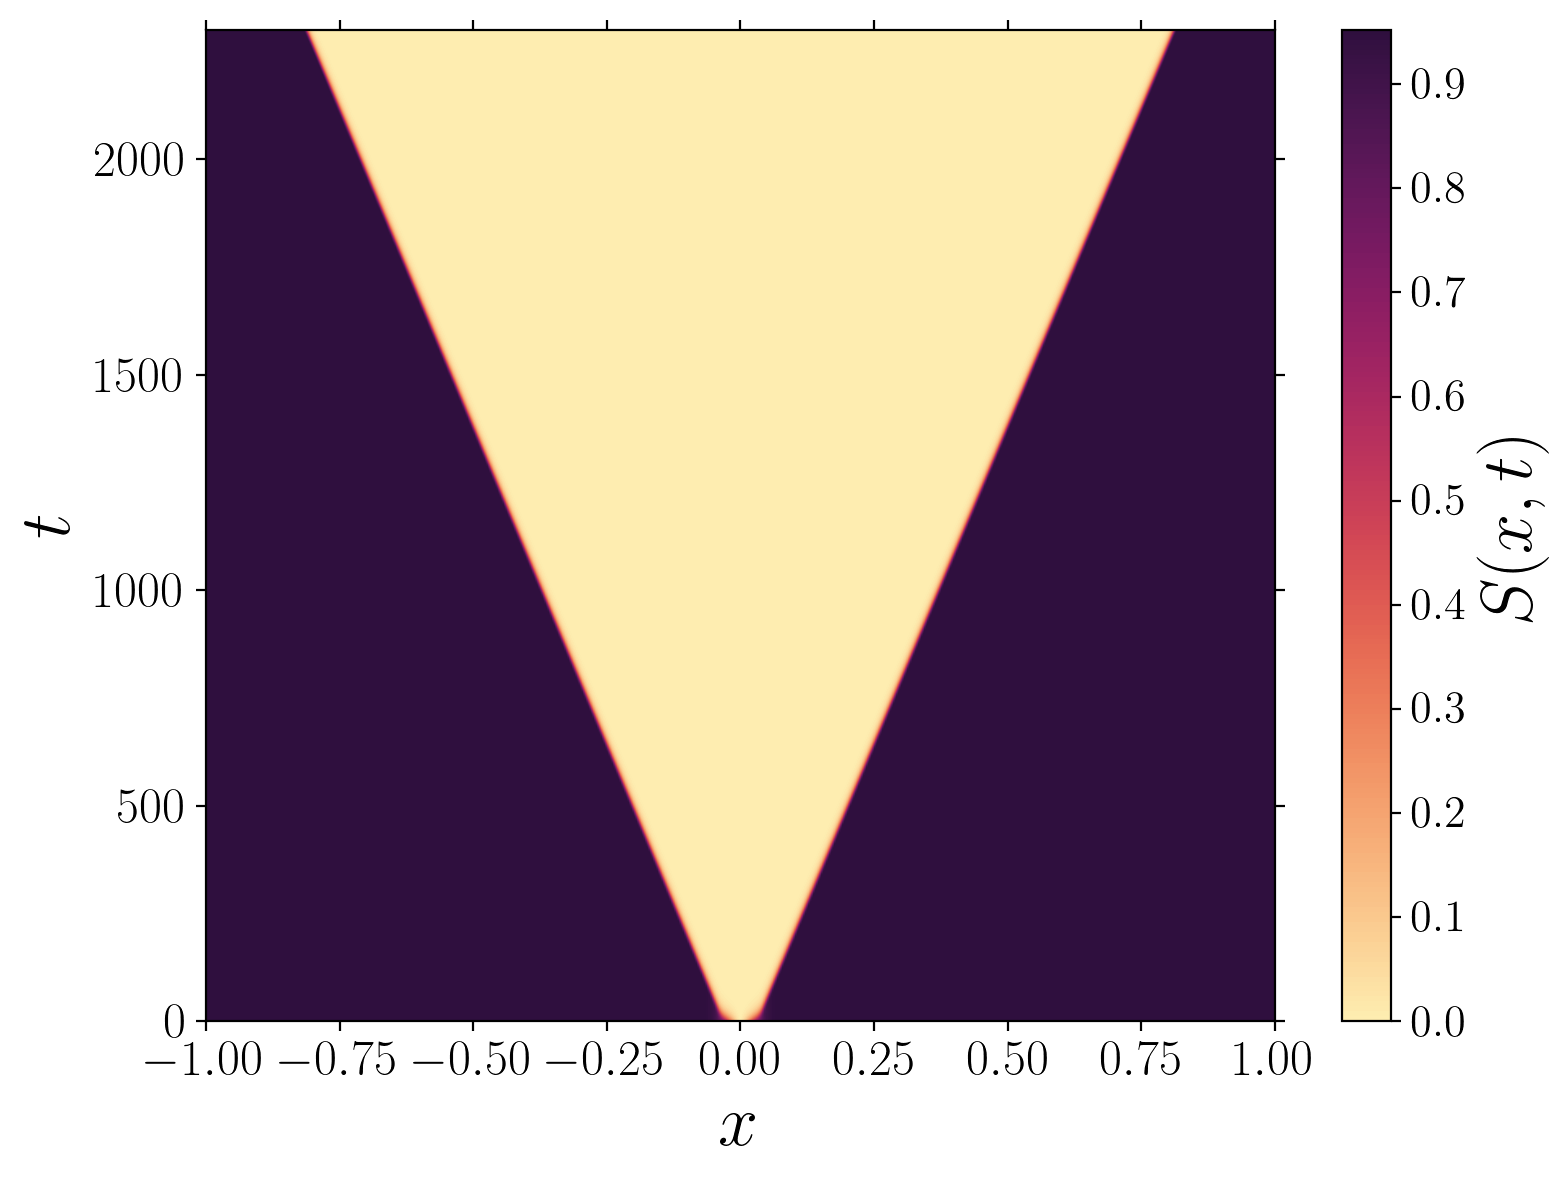

In [17]:
fig = plt.figure()

times = np.linspace(0., tmax, num=int(nsteps/ndump), endpoint=True)

CF = plt.contourf(x,times,udata[1,:,:], levels=200, cmap = cmo.matter)

# axis labels
plt.xlabel(r"$x$", fontsize=26, color = textcolor)
plt.ylabel(r"$t$", fontsize=26, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=18, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=18, rotation=0, color = textcolor)

# make colorbar
cbar = plt.colorbar(CF,  format='%.1f')
cbar.ax.tick_params(labelsize=16, color=textcolor) 
#plt.clim(0,np.amax(z))
cbar.ax.set_ylabel(r'$S(x,t)$', fontsize=26, color=textcolor)

# the final piece of the colorbar defn is to change the colorbar ticks to an acceptable color.
# This is not so easy, and relies on the thread at
# https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.set_size_inches(8,6)

plt.tight_layout()

plt.show()

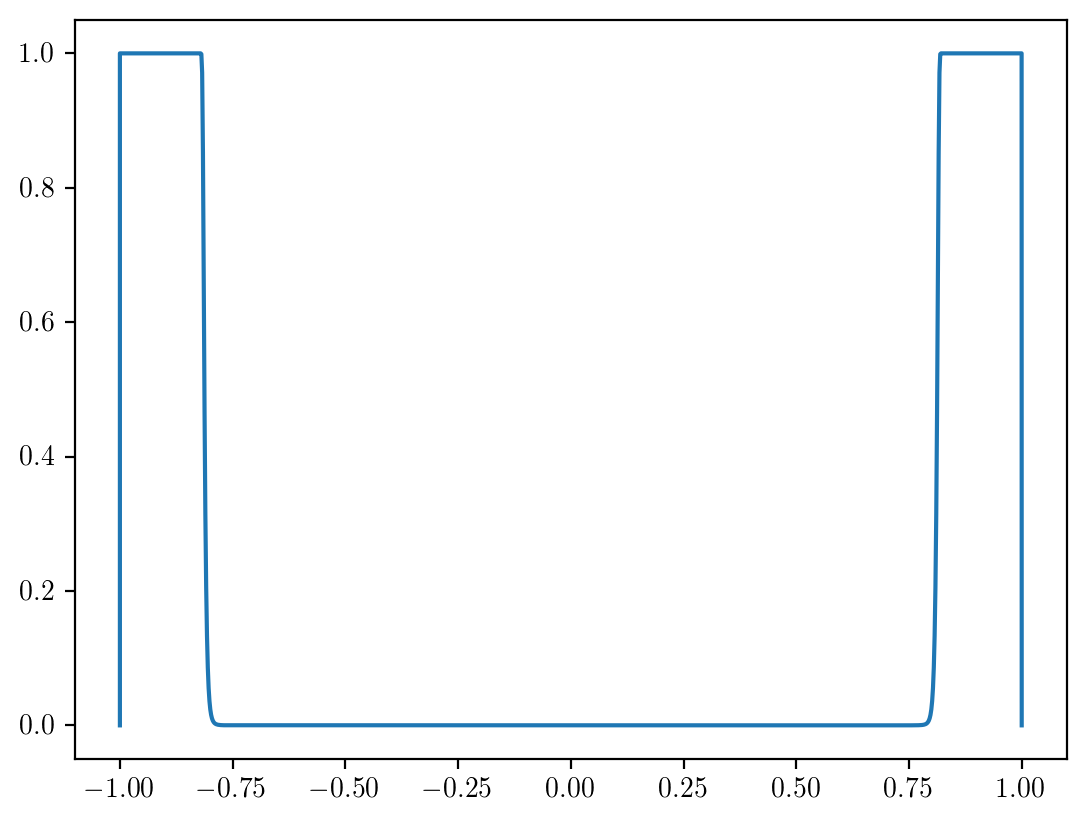

In [18]:
plt.plot(x, udata[1,-1,:])
plt.show()